# Data Science Jobs Vacancies

In this project, we shall apply **hierarchical clustering** and **K-means** in the [dataset](https://salaries.ai-jobs.net/download/) from the jobseeker website [ai-jobs](https://ai-jobs.net/). The purpose is to cluster job vacancies in the Data Science field by experience levels.

## Libraries

In [59]:
# Data and numerical operations
import numpy as np
import pandas as pd

# Graph and Charts
from matplotlib import pyplot as plt, colors as mcolors
import seaborn as sns

# Machine learning and statistics
import scipy.cluster.hierarchy as sch
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

## Reading and Cleaning data

In [3]:
# Read CSV
df = pd.read_csv("dataset.csv")

# Getting only the relevant columns
df = df[['job_title', 'experience_level']].sort_values('job_title')

# Function to counting entry-level vacancies
def count_exp_level(df, level):
    df = df.value_counts()
    
    if level in df.index: return df[level]
    else: return 0

# Aggregate over entry-level vacancies and average salary
df = df.groupby('job_title').agg(
    EN = ('experience_level', lambda x: count_exp_level(x, 'EN')),
    MI = ('experience_level', lambda x: count_exp_level(x, 'MI')),
    SE = ('experience_level', lambda x: count_exp_level(x, 'SE'))
)

# Select jobs with at least 10 vacancies
df = df.where(df.sum(axis = 1) >= 10).dropna().astype('int64')

df

,EN,MI,SE
job_title,,,
AI Scientist,7,3,1
Analytics Engineer,1,7,29
BI Data Analyst,5,6,0
Data Analyst,24,44,111
Data Architect,0,3,34
Data Engineer,18,81,199
Data Science Manager,0,4,21
Data Scientist,36,84,206
ETL Developer,0,2,8


## Understanding the data (descriptive statistics)

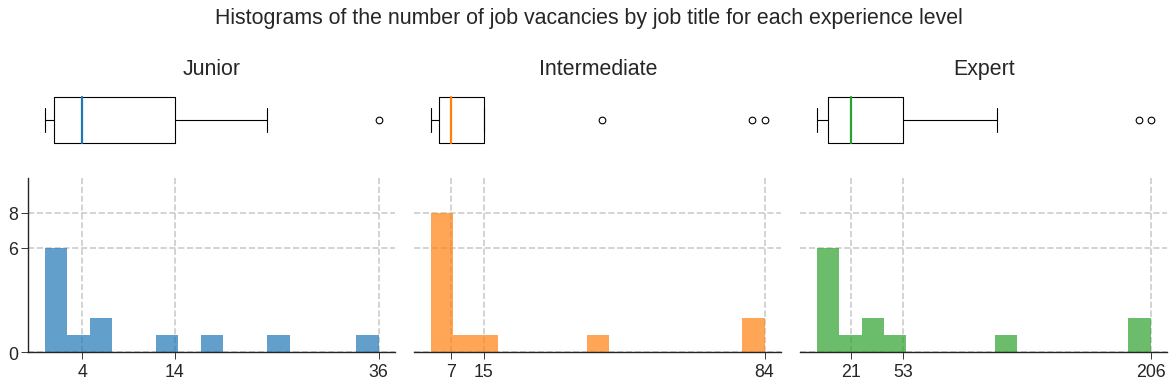

In [94]:
#---------- Figure and Axes ----------#

fig = plt.figure(figsize = (15, 5), dpi = 80)
gs = fig.add_gridspec(nrows = 3, ncols = 3)

plt.suptitle('Histograms of the number of job vacancies by job title for each experience level')

# Box and whiskers plots
ax_box = []
for i in range(3):
    ax_box.append(fig.add_subplot(gs[0, i]))
    
    # Remove spines and ticks and labels
    ax_box[-1].spines[:].set_visible(False)
    ax_box[-1].yaxis.set_visible(False)
    ax_box[-1].xaxis.set_visible(False)
    
# Histograms
ax_hist = []
for i in range(3):
    ax_hist.append(fig.add_subplot(gs[1:, i]))
    
    # Remove spines and ticks and labels
    if i > 0:
        ax_hist[-1].spines[['top', 'right', 'left']].set_visible(False)
        ax_hist[-1].yaxis.set_tick_params(left = False, labelleft = False)
        #ax_hist[-1].yaxis.set_visible(False)
        
    else:
        ax_hist[-1].spines[['top', 'right']].set_visible(False)
        
#---------- Style ----------#

plt.style.use('seaborn-ticks')
plt.rcParams.update({
    'font.size': 16
})

#---------- Box and Whiskers plots ----------#

titles = ['Junior', 'Intermediate', 'Expert']
for i in range(3):
    ax_box[i].set_title(titles[i])
    
    ax_box[i].boxplot(
        df.iloc[:, i],
        vert = False,
        widths = 0.6,
        medianprops = {
            'color': sns.color_palette()[i],
            'linewidth': 2
        }
    )
    
#---------- Histograms ----------#

hist_stats = []
for i in range(3):
    n, bins, patches = ax_hist[i].hist(
        df.iloc[:, i],
        color = sns.color_palette()[i],
        alpha = 0.7,
        bins = 15
    )
    
    hist_stats.append(n)
    
#---------- X and Y labels ----------#

for i in range(3):
    # Y-axis of the histograms
    ax_hist[i].set_ylim(0, np.max(hist_stats) + 2)
    ax_hist[i].set_yticks([0, np.max(hist_stats[0]), np.max(hist_stats)])
    ax_hist[i].grid(axis = 'both', linestyle = '--', linewidth = 1.5)
    
    # X-axis of the histograms
    ax_box[i].set_xlim(ax_hist[i].get_xlim())
    ax_hist[i].set_xticks([np.median(df.iloc[:,i]), np.quantile(df.iloc[:,i], 0.75), np.max(df.iloc[:, i])])



#----- Show and/or save figure -----#

plt.tight_layout()
plt.savefig('descriptive_statistics.png', dpi = 100)

In [95]:
df.describe().round(1)

,EN,MI,SE
count,13.0,13.0,13.0
mean,8.6,20.8,52.4
std,11.3,29.5,73.1
min,0.0,2.0,0.0
25%,1.0,4.0,7.0
50%,4.0,7.0,21.0
75%,14.0,15.0,53.0
max,36.0,84.0,206.0


The expert level (SE) is the most sought-after level since its mean, median, and maximum values are the highest of all experience levels, whereas the junior level (EN) is the least sought-after since its mean, median, and maximum values are the lowest. Furthermore, most job titles have few vacancies at all experience levels, whereas some titles are outliers and concentrate the vacancies. The intermediate level (MI) is the best example of this behaviour. We expect that these outliers will cluster apart from the others.

Since the amplitudes of each experience level are different, we shall scale the data (check this [link](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02) for more information) to avoid bias at a specific experience level. There are many methods for scaling data, such as **robust scaling**, **absolute maximum scaling**, **min-max scaling**, and **standardization** (the Z-score method). Robust scaling is not recommended for our case since we expected effects from outliers. Also, the maximum values of all experience levels are at least 2.6 times greater than the third quartile, which implies that the outliers are far away from the data. As a result, if we use the Min-Max or Absolute Maximum scaling, most values will be very close to zero, effectively negating the effect of most values except outliers. Thus, standardisation looks to be the better data scaling method for this analysis.

In [4]:
scaled_df = pd.DataFrame(StandardScaler().fit_transform(df), index = df.index, columns = df.columns)
scaled_df

,EN,MI,SE
job_title,,,
AI Scientist,-0.149241,-0.630179,-0.731663
Analytics Engineer,-0.703562,-0.488932,-0.332972
BI Data Analyst,-0.334014,-0.524244,-0.745902
Data Analyst,1.421338,0.817603,0.834622
Data Architect,-0.795949,-0.630179,-0.261778
Data Engineer,0.867016,2.124137,2.087650
Data Science Manager,-0.795949,-0.594867,-0.446884
Data Scientist,2.529982,2.230073,2.187322
ETL Developer,-0.795949,-0.665491,-0.631990


## Agglomerative hierarchical clustering

### Choosing a distance metric

We shall build and visualize (heatmap) the **proximity matrix** in order to analyze **distance metrics**. A proximity matrix is essentially a table with the distances between the observations and a distance is a measure of **dissimilarity**. The main properties of the proximity matrix are

- Its diagonal elements are all zeros;
- It is symmetric by the transpose operation. 

Choosing a proper distance measure is the most fundamental task in any clustering method. There are many possible distances, which one has advantages and disadvantages (check [this article](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa) to understand some of the most relevant distances). There are some features of the data we must take into account to choose a distance measure:

1. All variables are equally relevant;
2. We are mainly concerned with the magnitude differences between observations;
3. The variables space has low dimensionality (3 dimensions: EN, MI, and SE).

Let us consider both $ x_i $ and $ y_i $ arbitrary observations of the $i$-th variables. Assuming the features described above, we chose to analyze the following distance measures:

<table>
    <tr>
        <th style="text-align:center;">Euclidean</th>
        <th style="text-align:center;">Manhattan</th>
        <th style="text-align:center;">Chebyshev</th>
    </tr>
    <tr>
        <td> $$ d(x_i, y_i) = \sum_{i = 0}^{3} \sqrt{(x_i - y_i)^{2}} $$ </td>
        <td> $$ d(x_i, y_i) = \sum_{i = 0}^{3} |x_i - y_i| $$ </td>
        <td> $$ d(x_i, y_i) = \max_i |x_i - y_i| $$ </td>
    </tr>
<table>

#### Plotting the proximity matrices

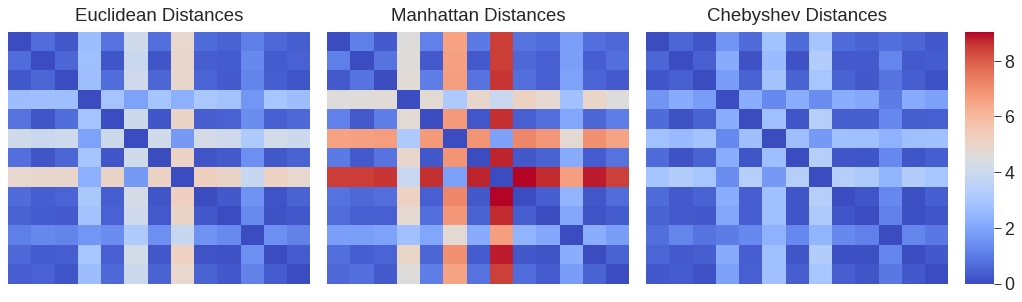

In [97]:
#---- Proximity Matrixes ----#

distances_names = ['euclidean', 'manhattan', 'chebyshev']
proximity_matrices = np.array([pairwise_distances(scaled_df, metric = dist) for dist in distances_names])
max_distance = np.max(proximity_matrices)

#----- Figure and Axes ------#

fig = plt.figure(figsize = (13,4), dpi = 80)
gs = fig.add_gridspec(nrows = 1, ncols = 22)

axs = [
    fig.add_subplot(gs[0, 0:7]),    # Euclidian distance
    fig.add_subplot(gs[0, 7:14]),   # Manhattan distance
    fig.add_subplot(gs[0, 14:21]),  # Chebyshev distance
    fig.add_subplot(gs[0, 21]),     # Colorbar
]

#---------- Style -----------#

plt.style.use('seaborn-ticks')
plt.rcParams.update({
    'font.size': 14
})

#-- Plot proximity matrices --#

for i in range(3):
    # Heatmap
    sns.heatmap(
        proximity_matrices[i], 
        ax = axs[i],
        xticklabels = False,
        yticklabels = False,
        cmap = sns.color_palette("coolwarm", as_cmap=True),
        cbar_ax = axs[-1],
        vmin = 0,
        vmax = max_distance
    )

    axs[i].set_title(distances_names[i].capitalize() + ' Distances', pad = 10)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    

#----- Show and/or save figure -----#

plt.tight_layout()
plt.savefig('distance_metrics.png', dpi = 100)

The Euclidean, Manhattan, and Chebyshev distances are very similar. Indeed, these distances came from the same distance measure (Minkowski distance) and, for one-dimensional data, they are all the same. For multi-dimensional data, the Euclidean and Chebyshev distances are less sensitive to differences in more than one variable than the Manhattan distance. We can notice this effect in the heatmaps above, in which the red and blue colours are stronger for Manhattan distances than for Euclidean and Chebyshev distances. The Manhattan distance looks better in our analysis since it treats the multi-dimensional data more equally than the others (see feature 1 listed above). However, since the data has low dimensionality, the Euclidean distance works as well. It also allows the use of the Ward method, which we shall describe further. In conclusion, we shall consider the **Euclidean distance** from now on.

In [98]:
proximity_matrix = pd.DataFrame(pairwise_distances(scaled_df, metric = 'euclidean'))
pd.merge(proximity_matrix, pd.DataFrame(df.index), how = 'outer', left_index = True, right_index = True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,job_title
0,1.490116e-08,0.697264,0.213463,2.648780,0.799390,4.070327,0.707516,4.886691,0.655297,0.490544,1.070523,0.565296,0.375714,AI Scientist
1,6.972644e-01,0.000000,0.555269,2.754181,0.183180,3.892847,0.180924,4.919419,0.359333,0.326597,1.280258,0.321119,0.452574,Analytics Engineer
2,2.134630e-01,0.555269,0.000000,2.716592,0.677483,4.060223,0.554782,4.938880,0.496297,0.296648,1.166997,0.384379,0.183180,BI Data Analyst
3,2.648780e+00,2.754181,2.716592,0.000000,2.866100,1.893247,2.924670,2.248102,3.044155,2.833913,1.607557,2.933375,2.670890,Data Analyst
4,7.993902e-01,0.183180,0.677483,2.866100,0.000000,3.983908,0.188444,5.024037,0.371893,0.449328,1.387688,0.401654,0.606775,Data Architect
5,4.070327e+00,3.892847,4.060223,1.893247,3.983908,0.000000,4.072137,1.669315,4.236027,4.060453,3.144824,4.140413,3.948324,Data Engineer
6,7.075156e-01,0.180924,0.554782,2.924670,0.188444,4.072137,0.000000,5.097170,0.198121,0.291723,1.425279,0.222533,0.483072,Data Science Manager
7,4.886691e+00,4.919419,4.938880,2.248102,5.024037,1.669315,5.097170,0.000000,5.233988,5.028804,3.848872,5.125119,4.874377,Data Scientist
8,6.552968e-01,0.359333,0.496297,3.044155,0.371893,4.236027,0.198121,5.233988,0.000000,0.255963,1.514669,0.141281,0.467112,ETL Developer
9,4.905441e-01,0.326597,0.296648,2.833913,0.449328,4.060453,0.291723,5.028804,0.255963,0.000000,1.318297,0.116289,0.214883,ML Engineer


### Linkage method

Once we define a distance metric, the next step for performing agglomerative hierarchical clustering is to define a method to link clusters, which is called **linkage**. Let us consider two arbitrary cluster $u$ and $v$. We shall denotated the observations in each cluster as $u[i]$ and $v[j]$, where $ u[i] $ is a observation in the cluster $ u $ and $ v[j] $ is a observation in the cluster $ v $. Also, we shall denoted the distance between two observations as $ dist $, which depends on the chosen metric. The distance between the mentioned clusters for the main linkage methods are

<table>
        <tr>
            <th style="text-align: center;"> Method </th>
            <th style="text-align: center;"> Calculation </th>
            <th style="text-align: center;"> Features </th>
        </tr>
        <tr>
            <td style="text-align: center;"><b> Single or minimum </b></td>
            <td> $$ d(u, v) = \min_{i,j}\{dist(u[i], v[j])\} $$ </td>
            <td style="text-align: left"> This method tends to yield large clusters since it is suceptible to the <b>chaining effect</b> [2]. Also, it is good for identifing <b>non-globular data</b>, but it performs poorly on noisy data [2]. Usually, this linkage method is not a good choice unless we want to detect non-globular data. </td>
        </tr>
        <tr>
            <td style="text-align: center;"><b> Complete or maximum </b></td>
            <td> $$ d(u, v) = \max_{i,j}\{dist(u[i], v[j])\} $$ </td>
            <td style="text-align: left"> This method is less sensitive to the <b>chaining effect</b>, and therefore, it performs better than the single linkage method on noisy data [2]. Also, it tends to yield compact clusters of approximately the same size. Overall, it is good to find cleanly separated <b>globular data</b>.</td> 
        </tr>
        <tr>
            <td style="text-align: center;"><b> Average or UPGMA [3]</b></td>
            <td> $$ d(u, v) = \sum_{i,j} \frac{\{dist(u[i], v[j])\}}{|u| \cdot |v|} $$ </td>
            <td style="text-align: left"> This method is similar to the complete linkage but it performs better for noisy data. It is more used than the single and complete linkages. </td>
        </tr>
        <tr>
            <td style="text-align: center;"><b> Centroid </b></td>
            <td> $$ d(u, v) = \left| c_i - c_j \right| $$ </td>
            <td style="text-align: left"> The centroid linkage results somewhat similarly to the average linkage, but we must be cautious when using it since there is the possibility of <b>inversion</b>. </td>
        </tr>
        <tr>
            <td style="text-align: center;"><b> Ward </b></td>
            <td style="text-align: center"> Variance Minimization Algorithm </td>
            <td style="text-align: left"> The Ward method behaves similar to the average linkage but it is the best one for noisy data (check the the <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html">scikit-learn documentation</a>). It is said to be the most suitable method for quantitative variables. </td>
        </tr>
</table>

where $ |u| $ and $ |v| $ are the number of observations in the clusters $ u $ and $ v $ respectively, and $ c_u $ and $ c_j $ are the centroids of $ u $ and $ v $ respectively (check this [link](https://sciencing.com/approximate-mean-group-data-10041121.html) to learn how to calculate cluster centroids). 

[1] The chaining effect merge two clearly separated cluster into one.

[2] When we say that a linkage method performs poorly in noisy data, we mean that it joins outliers to distant clusters.

[3] UPGMA = Unweighted pair-group method using arithmetic averages

### Plotting data

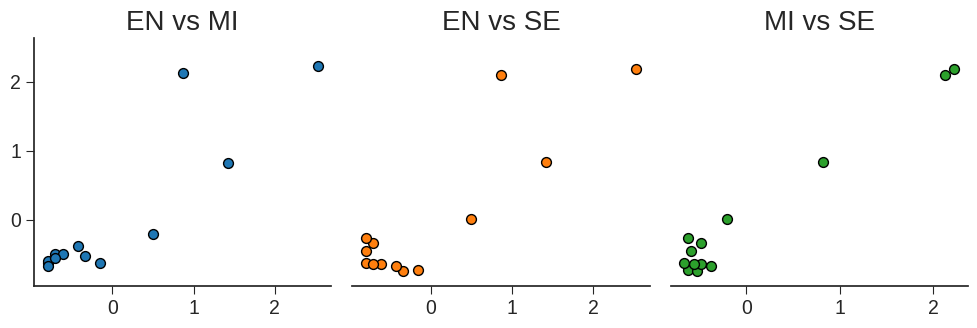

In [23]:
#----- Set figure and Axis -----#

fig = plt.figure(figsize = (10, 3.5), dpi = 100)
gs = fig.add_gridspec(nrows = 1, ncols = 3)

ax = []
for i in range(3):
    ax.append(fig.add_subplot(gs[0, i]))
    
    # Remove spines
    if i > 0: 
        ax[-1].spines[['top', 'right', 'left']].set_visible(False)
        ax[-1].yaxis.set_visible(False)
        
    else: ax[-1].spines[['top', 'right']].set_visible(False)
        
    ax[-1].set_ylim(scaled_df.min().min()*1.2, scaled_df.max().min()*1.2)
        
#----- Style -----#

plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})

#----- Scatter plots -----#

titles = ['EN vs MI', 'EN vs SE', 'MI vs SE']
idxs = [(0, 1), (0, 2), (1, 2)]

for i in range(3):
    ax[i].set_title(titles[i], fontsize = 20)
    ax[i].scatter(
        scaled_df.iloc[:,idxs[i][0]],
        scaled_df.iloc[:,idxs[i][1]],
        color = sns.color_palette()[i],
        s = 50,
        linewidth = 1,
        edgecolor = 'black'
    )

#----- Show and/or save figure -----#

plt.tight_layout()
plt.savefig('scatter_plots_data.png', dpi = 100)

From the scatter plots above, we can clearly see that most job titles form a single globular cluster. Furthermore, as previously discussed, there are four outliers that can form different distant clusters. The single and complete methods are not ideal since they do not handle well with outliers. Therefore, the average and Ward linkages seen to be the best options for this project.

### Plotting a dendrogram through Scipy library

**Dendrograms** are visual representations of the hierarchical relationship between observations. They are used to choose the **number of clusters**. We shall consider two options for the number of clusters: the first one denoted in the dendrograms as a solid vertical line and the second one denoted as a dashed vertical line.

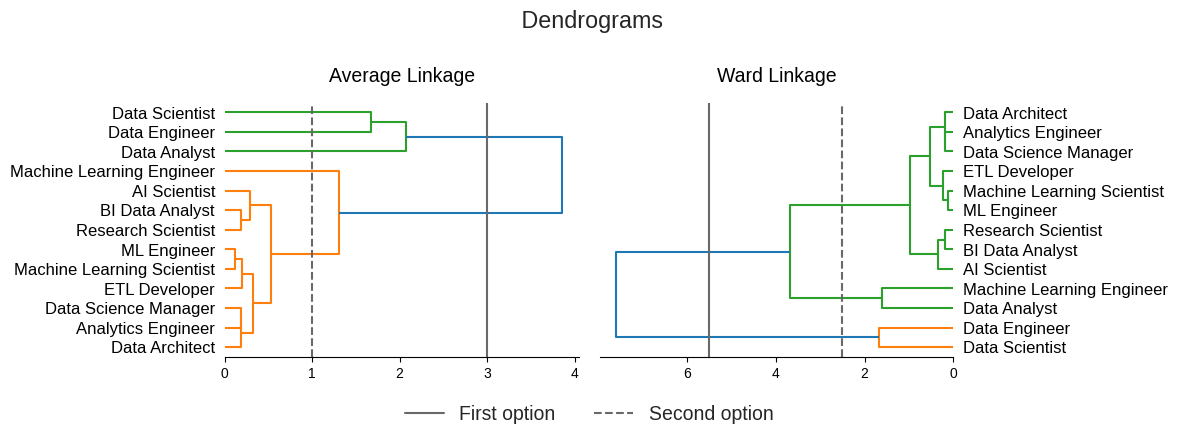

In [5]:
#----- Figure and Axes -----#

fig = plt.figure(figsize = (12, 4), dpi = 100)
gs = fig.add_gridspec(nrows = 1, ncols = 2)

ax = []
for j in range(2):
    ax.append(fig.add_subplot(gs[0, j]))

    ax[-1].spines[['top', 'right', 'left']].set_visible(False)
    ax[-1].set_yticks([])
    #ax[-1].set_xticks([])
        
#----- Style -----#

plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})

#----- Dendrograms -----#

titles = ['Average Linkage', 'Ward Linkage']
linkage_methods = ['average', 'ward']

for i in range(len(linkage_methods)):
    # Orientation
    if i % 2 == 0: side = 'right'
    else: side = 'left'
        
    # Title
    ax[i].set_title(titles[i], pad = 15, fontsize = 14)
        
    # Dendogram
    sch.dendrogram(
        sch.linkage(scaled_df, method = linkage_methods[i], optimal_ordering = True),
        orientation = side,
        labels = scaled_df.index,
        ax = ax[i]
    )
    
#----- Number of clusters -----#

# Average linkage
ax[0].axvline(3, label = "First option", linestyle = '-', color = 'dimgrey')
ax[0].axvline(1, label = 'Second option', linestyle = '--', color = 'dimgrey')

# Ward linkage
ax[1].axvline(5.5, label = "First option", linestyle = '-', color = 'dimgrey')
ax[1].axvline(2.5, label = 'Second option', linestyle = '--', color = 'dimgrey')

#----- Legends and titles -----#

plt.suptitle(' Dendrograms')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc = 'lower center',
    ncol = 2,
    bbox_to_anchor = (0.5, -0.1)
) 

#----- Show and/or save figure -----#

plt.tight_layout()    
plt.savefig('dendrograms.png', dpi = 100)

The average and Ward linkages yield similar clusters for the first option. The only difference is the data analyst title, which is in the smaller cluster using average linkage and in the largest cluster using Ward linkage. In both methods, the data scientist, data engineer, data analyst, and machine learning engineer titles are the distant observations, and they form the distant clusters. This is expected since these four titles are outliers. The second option using average linkage puts the outliers in separeted clusters and all other job titles are in a single cluster, whereas by using Ward linkage the outliers are separeted in two cluster and all the other job titles are in a single cluster. We seek compact clusters such that only fairly similar observations are merged into a cluster. Therefore, we shall consider the second option for both methods, which means 5 clusters for the average linkage and 3 clusters for the Ward linkage.

### Getting clusters through Scikit-Learn library

In [25]:
#----- Defining Estimators and fitting them to the data -----#
fitted_models = [
    AgglomerativeClustering(n_clusters = 5, linkage = 'average').fit(scaled_df),
    AgglomerativeClustering(n_clusters = 3, linkage = 'ward').fit(scaled_df)
]

### Plotting scatter plots with the clusters

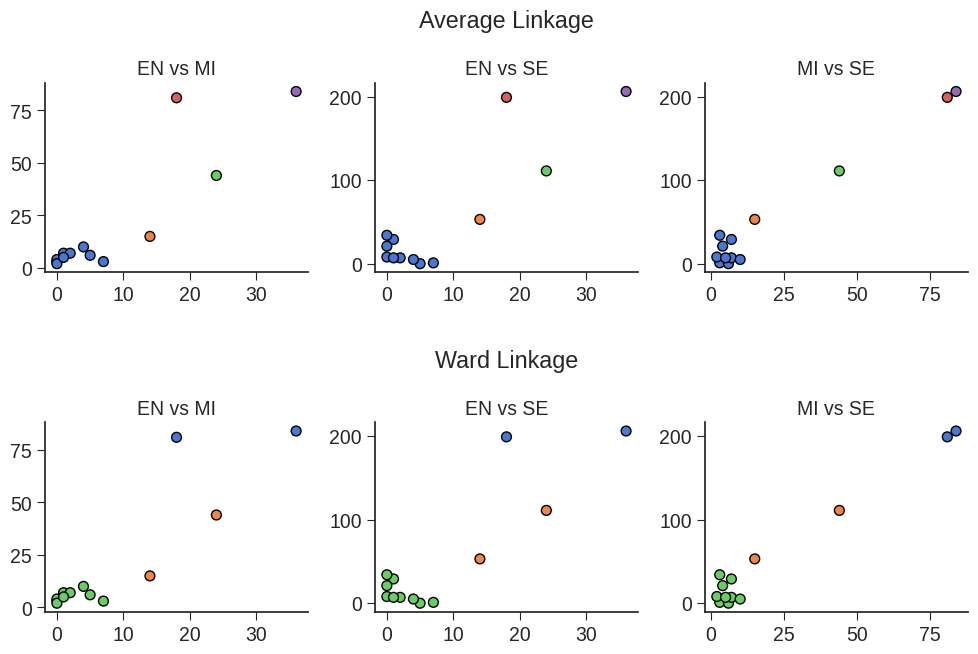

In [26]:
#----- Set figure and Axis -----#

fig = plt.figure(figsize = (10, 7), dpi = 100)
gs = fig.add_gridspec(nrows = 2, ncols = 3)

ax = []
for i in range(2):
    for j in range(3):
        ax.append(fig.add_subplot(gs[i, j]))

        # Remove spines
        ax[-1].spines[['top', 'right']].set_visible(False)
        
#----- Style -----#

plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})

#----- Scatter plots -----#

suptitles = ['Average Linkage', 'Ward Linkage']
titles = ['EN vs MI', 'EN vs SE', 'MI vs SE']
cols = [('EN', 'MI'), ('EN', 'SE'), ('MI', 'SE')]

for i in range(2):
    big_axes = fig.add_subplot(gs[i, :])
    big_axes.set_title(suptitles[i], pad = 40)
    big_axes.set_axis_off()
    
    for j in range(3):        
        sns.scatterplot(
            data = df,
            x = cols[j][0],
            y = cols[j][1],
            ax = ax[i*3 + j],
            hue = fitted_models[i].labels_,
            legend = False,
            s = 50,
            linewidth = 1,
            edgecolor = 'black',
            palette = 'muted'
        )
        
        ax[3*i + j].set_title(titles[j], fontsize = 14)
        ax[3*i + j].set_xlabel('')
        ax[3*i + j].set_ylabel('')
        

#----- Show and/or save figure -----#

plt.tight_layout()
plt.savefig('scatter_plots_with_clusters.png', dpi = 100)

The average linkage yields the most compacted clusters, whereas the Ward linkage results in more spread clusters. Since we want compacted clusters, we shall consider the clusters formed by the average linkage method. Let us evaluated a descriptive statistics for each cluster.

In [68]:
#----- Grouping by clusters -----#

df['Cluster'] = fitted_models[0].labels_ + 1

# Changing display style
from IPython.display import display_html
def display_side_by_side(*args):
    html_str = ''
    
    for df in args:
        html_str += df.to_html()
        
    display_html(html_str.replace('table','table style="display:inline; padding-right: 20px"'), raw=True)

display_side_by_side(df[df['Cluster'] == 1].drop('Cluster', axis = 1).describe().round(1), df[df['Cluster'] > 1])

EN 
 MI 
 SE 
 
 
 
 
 count 
 9.0 
 9.0 
 9.0 
 
 
 mean 
 2.2 
 5.2 
 12.4 
 
 
 std 
 2.5 
 2.5 
 12.4 
 
 
 min 
 0.0 
 2.0 
 0.0 
 
 
 25% 
 0.0 
 3.0 
 5.0 
 
 
 50% 
 1.0 
 5.0 
 7.0 
 
 
 75% 
 4.0 
 7.0 
 21.0 
 
 
 max 
 7.0 
 10.0 
 34.0 
 
 
 
 
 
 
 EN 
 MI 
 SE 
 Cluster 
 
 
 job_title 
 
 
 
 
 
 
 
 
 Data Analyst 
 24 
 44 
 111 
 3 
 
 
 Data Engineer 
 18 
 81 
 199 
 4 
 
 
 Data Scientist 
 36 
 84 
 206 
 5 
 
 
 Machine Learning Engineer 
 14 
 15 
 53 
 2

Essentially, the clustering algorithm identifies the outliers. The job titles with the fewest vacancies are merged into a single cluster, whereas the job titles with the most vacancies form all the other clusters with single observations.

## K-Means